100%|███████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 388.99it/s]


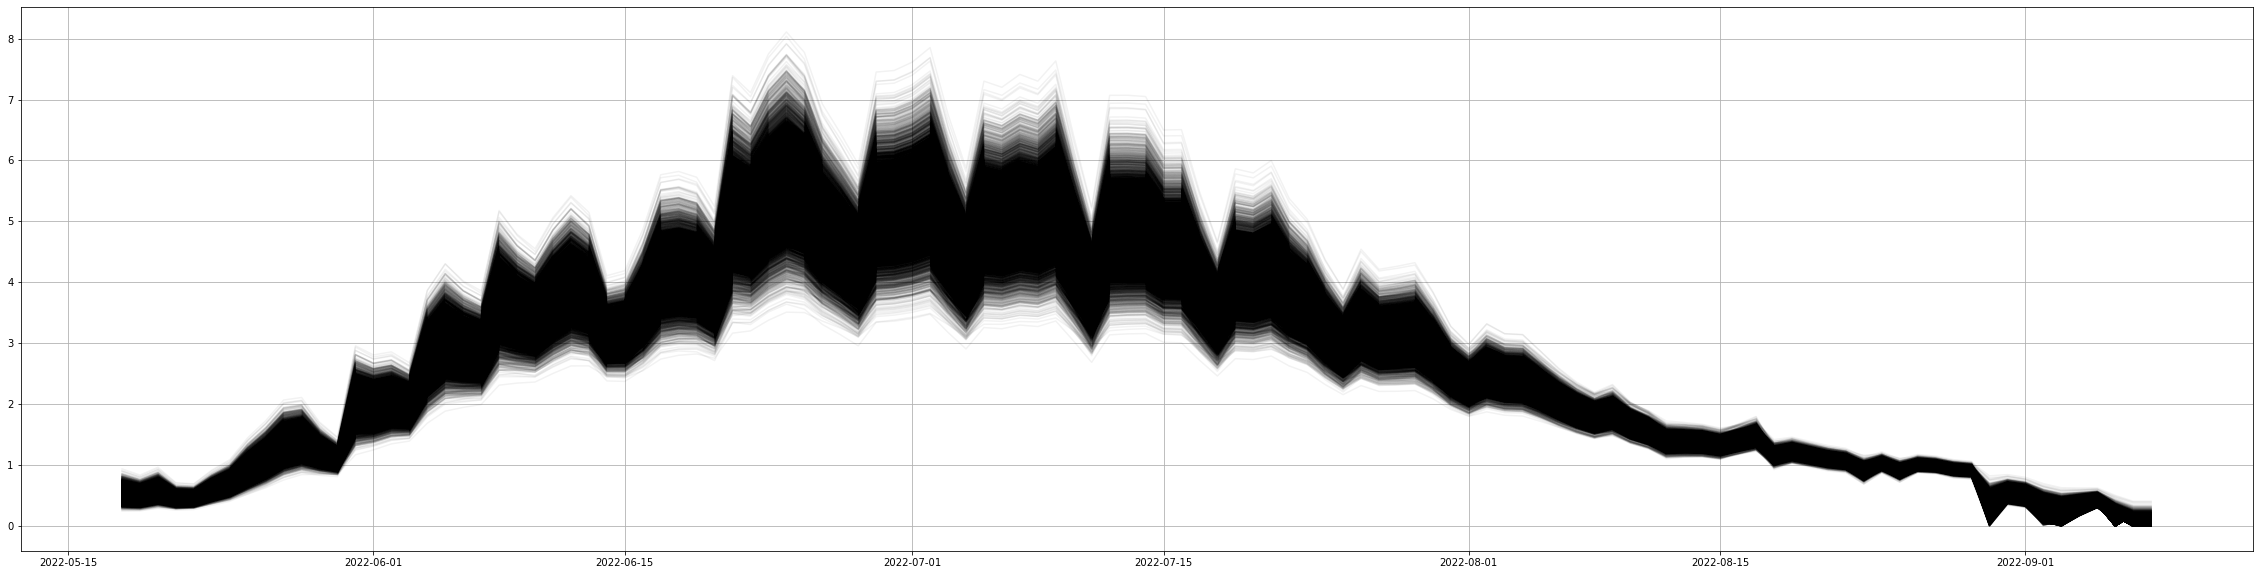

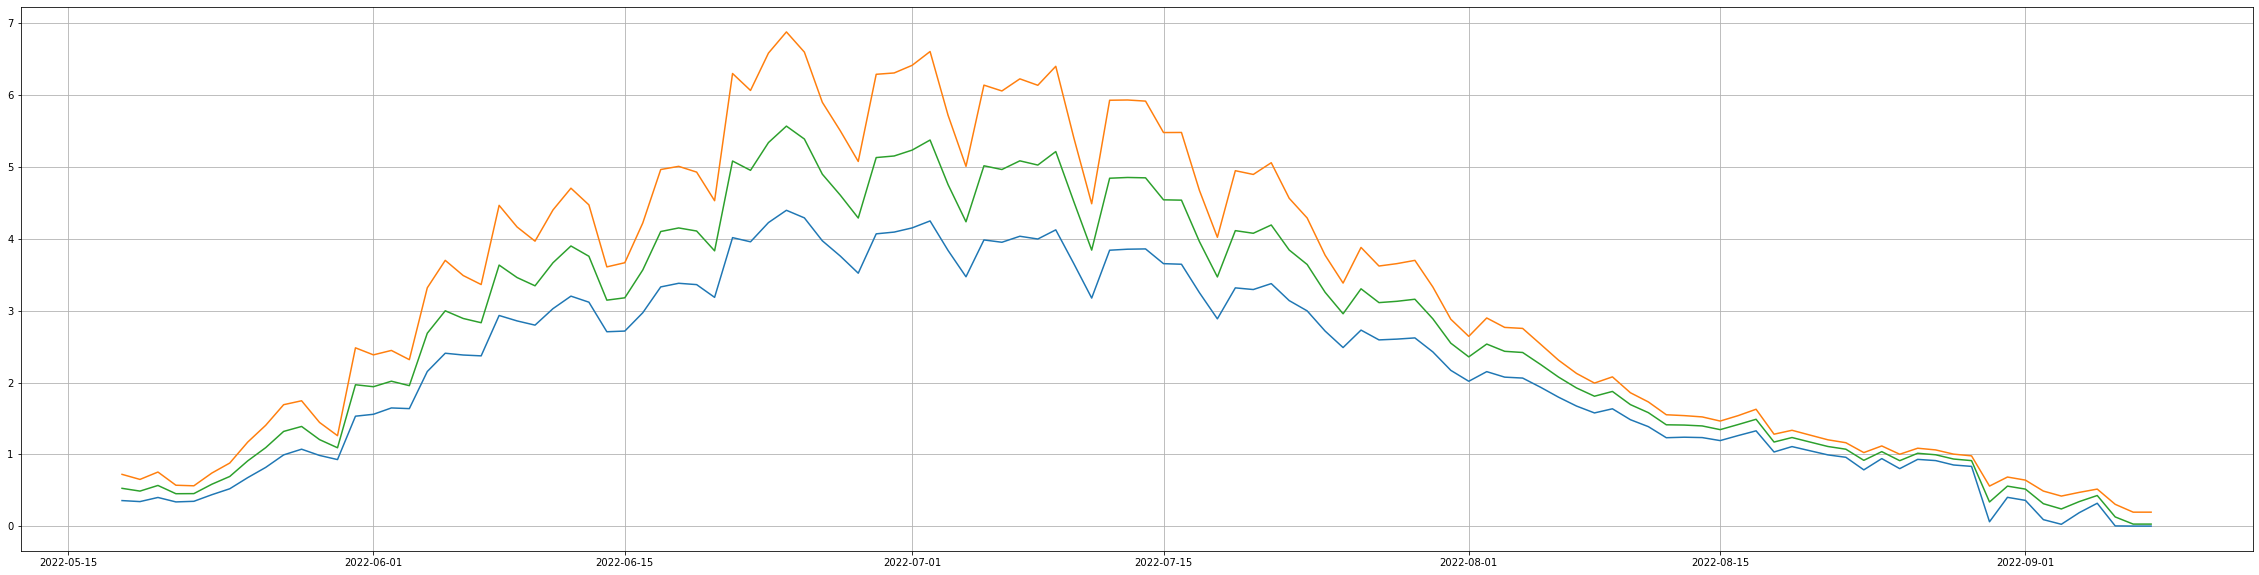

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import savgol_filter
from numpy import random
from tqdm import tqdm, trange
import numba as nb
data = pd.read_csv('timeseries-country-confirmed.csv', usecols=['Date', 'Cases', 'Country'])
C1 = data[data['Country'] == 'United States']
C1 = C1[C1['Date'] > '2022/5/17']
date = np.array(C1['Date'].astype(str))
xs = [datetime.strptime(d, '%Y/%m/%d').date() for d in date]
C = C1['Cases'].values

def moving_average(interval, windowsize):
    window = np.ones(int(windowsize)) / float(windowsize)
    re = np.convolve(interval, window, 'same')
    return re
plt.figure(figsize=(40, 10))

def RLS(x, y):
    l = 0.65  
    R = {}
    z = {}
    P = {}
    w = {}
    k = {}
    R[0] = x[0] * x[0]
    z[0] = x[0] * y[0]
    P[0] = 1 / R[0]
    w[0] = (1 / R[0]) * z[0]
    for i in range(1, len(x)):
        k[i] = (P[i - 1] * x[i]) / (l + x[i] * P[i - 1] * x[i])
        P[i] = (1 / l) * P[i - 1] - (1 / l) * k[i] * x[i] * P[i - 1]
        w[i] = w[i - 1] - k[i] * (x[i] * w[i - 1] - y[i])
        w[i]=abs(w[i])
    return w
qc = random.normal(loc=8.7, scale=1.6, size=10000)
gc = random.normal(loc=21, scale=7 / 3, size=10000)
Rta={}
for k in tqdm(range(len(qc))):
    Su = {}
    I = {}
    SA = {}
    X = {}
    Y = {}
    Bu = {}
    R = {}
    T = {}
    Rt = {}
    Ep = {}
    theta = 0.76  
    SA[0] = 332854719 * (1 - theta)
    Su[0] = 332854719 * theta
    I[0] = 26  
    Ep[0] = 26 * 8  
    R[0] = 0
    T[0] = 0
    d = 0.0081
    N = 332854719  
    a = random.choice(qc)
    b = random.choice(gc)
    q = 1/a
    g = 1/b
    E = np.zeros(len(C))
    C = C1['Cases'].values
    C =moving_average(C,14)
    for i in range(len(C)):
        E[i] = C[i] / q 
    for t in range(len(C) - 1):
        I[t + 1] = I[t] + 0.983* q * E[t] - g * I[t]
        R[t + 1] = R[t] + g *(1-0.983)* E[t] + g * I[t] 
        Y[t] = E[t + 1] - E[t] + I[t+1]-I[t] +R[t+1]-R[t]
        X[t] = (0.15 * SA[t] * I[t] + Su[t] * I[t]) / N
        Bu = RLS(X, Y)
        SA[t + 1] = SA[t] - Bu[t] * 0.15 * SA[t] * I[t] / N
        Su[t + 1] = Su[t] - Bu[t] * Su[t] * I[t] / N
        Rt[t] = 0.983 / g  * (Bu[t] * 0.15 * SA[t] + Bu[t] * Su[t]) / N
        Ep[t + 1] = Ep[t] + Bu[t] * 0.15 * SA[t] * I[t] / N + Bu[t] * Su[t] * I[t] / N - q * Ep[t]
        T[t + 1] = T[t] + 0.983* q * Ep[t]
    Rt[len(C)-1]=Rt[len(C)-2]
    Rta[k]=Rt
    plt.plot(xs,list(Rt.values()),color='black',alpha=0.05)
plt.grid()
Rtz = {}
time_Rt = {}
Rt_up = {}
Rt_low = {}

for m in tqdm(range(len(Rt))):
    for i in range(len(qc)):
        time_Rt[i] = Rta[i][m]
    Rtz[m] = time_Rt
    time_Rt={}
for n in tqdm(range(len(Rt))):
    Rt_up[n] = np.percentile(list(Rtz[n].values()),2.5)
    Rt_low[n] = np.percentile(list(Rtz[n].values()),97.5)
    Rt_up[n] = abs(Rt_up[n])
plt.figure(figsize=(40, 10))
Rt_up[len(C)-1]=Rt_up[len(C)-2]
Rt_low[len(C)-1]=Rt_low[len(C)-2]
plt.plot(xs,list(Rt_up.values()))
plt.plot(xs,list(Rt_low.values()))
plt.plot(xs,list(Rt.values()))
plt.grid()
